In [1]:
#from mpi4py import MPI 
import netket as nk
import netket.experimental as nkx
import nqs.BeH2_ptutorial as bpm
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings('ignore')

In [2]:
# get data to build the qubit Hamiltonian for toy problem in forrmat (P_ks + interactions)

H_constituents = [['ZZIIIII', 7.5],
 ['ZIZIIII', 10.0],
 ['ZIIZIII', 8.75],
 ['ZIIIZII', 2.5],
 ['ZIIIIZI', 5.0],
 ['ZIIIIIZ', 10.0],
 ['ZIIIIII', -14.0],
 ['IZZIIII', 12.0],
 ['IZIZIII', 10.5],
 ['IZIIZII', 3.0],
 ['IZIIIZI', 6.0],
 ['IZIIIIZ', 12.0],
 ['IZIIIII', -15.5],
 ['IIZZIII', 14.0],
 ['IIZIZII', 4.0],
 ['IIZIIZI', 8.0],
 ['IIZIIIZ', 16.0],
 ['IIZIIII', -20.5],
 ['IIIZZII', 3.5],
 ['IIIZIZI', 7.0],
 ['IIIZIIZ', 14.0],
 ['IIIZIII', -19.5],
 ['IIIIZZI', 2.0],
 ['IIIIZIZ', 4.0],
 ['IIIIZII', -6.0],
 ['IIIIIZZ', 8.0],
 ['IIIIIZI', -12.0],
 ['IIIIIIZ', -24.0],
 ['IIIIIII', 41.75]]

In [3]:
# get the paulis and the interaction coefficients
interactions = [ Pk_int[1] for Pk_int in H_constituents]
paulis = [ Pk_int[0] for Pk_int in H_constituents]

In [4]:
print(paulis[:3])
print(interactions[:3])

['ZZIIIII', 'ZIZIIII', 'ZIIZIII']
[7.5, 10.0, 8.75]


In [71]:
# Define some parameters + get paths to data

N = 7          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 100     # Batch size
epochs = 300   # Epochs
n_train_samples= 1000 # start with smalll number before using ns

# note the ed + ground state - diagonalize that H
ed_energy = -12 # confirm
psi0 = np.array([0,1,1,0,0,0,0]) # conf


In [72]:
# quick build: from tutorial library: modified input
def BuildHamiltonian(N,hilbert,pauliz, interactionz):
    hamiltonian = nk.operator.LocalOperator(hilbert, 0.0)                                                                              
    for h in range(0,len(pauliz)):                                                                                           
        # treat Identity ops the same as other ops                                                                   
        sites,operator = bpm.OperatorFromString(pauliz[h ])                         
        h_term = interactionz[h]*operator
        hamiltonian = hamiltonian + nk.operator.LocalOperator(hilbert,h_term,sites)     
    return hamiltonian

In [73]:
# build rbm + sampler + driver etc -- start with Hamiltonian first

# Hilbert space
hi = nk.hilbert.Qubit(N=N)
# NetKet Hamiltonian
hamiltonian = BuildHamiltonian(N,hi,paulis,interactions)

In [74]:
# After building Hamiltonian, check it:
print("\n=== HAMILTONIAN CHECK ===")
print(f"Hamiltonian type: {type(hamiltonian)}")
print(f"Hamiltonian dtype: {hamiltonian.dtype}")

# Try to compute energy on a random state
test_state = np.random.randn(2**N) + 1j * np.random.randn(2**N)
test_state = test_state / np.linalg.norm(test_state)

# Manual energy calculation
H_matrix = hamiltonian.to_dense()  # Get full matrix
test_energy = np.vdot(test_state, H_matrix @ test_state).real
print(f"Test energy on random state: {test_energy}")
print(f"ED ground state energy: {ed_energy}")


=== HAMILTONIAN CHECK ===
Hamiltonian type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Hamiltonian dtype: float64
Test energy on random state: 38.15191457841364
ED ground state energy: -12


In [75]:
# Another check to make sure we can actually get that ground state

# Get the Hamiltonian as a dense matrix
H_matrix = hamiltonian.to_dense()

print("\n=== HAMILTONIAN ANALYSIS ===")
print(f"Hamiltonian shape: {H_matrix.shape}")
print(f"Is Hermitian? {np.allclose(H_matrix, H_matrix.conj().T)}")

# Get eigenvalues + eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
print(f"\nLowest 5 eigenvalues:")
print(eigenvalues[:5])
print(f"Highest 5 eigenvalues:")
print(eigenvalues[-5:])

print(f"\nED ground state energy: {ed_energy}")
print(f"Hamiltonian ground state: {eigenvalues[0]}")

ground_state = eigenvectors[:, 0]
print(f"\nGround state eigenvector shape: {ground_state.shape}")

# get exact ground state and compare with the one they got:
print("Ground state:", ground_state)


=== HAMILTONIAN ANALYSIS ===
Hamiltonian shape: (128, 128)
Is Hermitian? True

Lowest 5 eigenvalues:
[-12.  -10.   -9.5  -8.5  -8.5]
Highest 5 eigenvalues:
[188.  205.5 225.  271.  321. ]

ED ground state energy: -12
Hamiltonian ground state: -12.0

Ground state eigenvector shape: (128,)
Ground state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Function to build the base operators properly -- SAVIOUR RIGHT HERE!
def BuildBases(hilbert,bases_array):
    base_ops = []
    for basis_string in bases_array:
        
        basis_string = str(basis_string)
        sites,operator = bpm.OperatorFromString(basis_string)
        base_operator = nk.operator.LocalOperator(hilbert,operator,sites)
        base_ops.append(base_operator)
    return np.array(base_ops,dtype=object)

In [77]:
# TRAIN RBM
# generate training data -- in bkp_toy1 script

# load the data

data = np.load('../Scripts/synthetic_measurements_M100000.npz', allow_pickle=True)

# Access the arrays
bitstrings = data['bitstrings']
bases = data['bases']
ground_state_ = data['ground_state']
hamiltonian_terms = data['hamiltonian_terms']
ground_state_energy = data['ground_state_energy']
n_qubits = data['n_qubits']

# Example: look at first few samples
print(f"Sample 1: bitstring={bitstrings[0]}, basis={bases[0]}")
print(f"Sample 2: bitstring={bitstrings[1]}, basis={bases[1]}")
print(f"\nGround state energy: {ground_state_energy}")
print(f"Number of samples: {len(bitstrings)}")

print("First 10 bitstrings:")
print(bitstrings[:10])
print("\nFirst 10 bases:")
print(bases[:10])
print("\nUnique bases:")
print(np.unique(bases))
print("\nUnique bitstrings:")
unique, counts = np.unique(bitstrings, return_counts=True)
print(f"Total unique: {len(unique)}")
print("Most common bitstring and count:")
most_common_idx = np.argmax(counts)
print(f"{unique[most_common_idx]}: {counts[most_common_idx]} times")
# make sure that ns < train_samples

Sample 1: bitstring=0110000, basis=ZZZZZZZ
Sample 2: bitstring=0110000, basis=ZZZZZZZ

Ground state energy: -12.0
Number of samples: 100000
First 10 bitstrings:
['0110000' '0110000' '0110000' '0110000' '0110000' '0110000' '0110000'
 '0110000' '0110000' '0110000']

First 10 bases:
['ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ'
 'ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ']

Unique bases:
['ZZZZZZZ']

Unique bitstrings:
Total unique: 1
Most common bitstring and count:
0110000: 100000 times


In [78]:
paulis[0]

'ZZIIIII'

In [79]:
str(bases[0])

'ZZZZZZZ'

In [80]:
hamiltonian

LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)

In [81]:
base_op_test = BuildBases(hi,bases[:3])
base_op_test

# do it for all of the bases:

base_operators = BuildBases(hi,bases)

In [82]:
base_operators[:10]

array([LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)],
      dtype=object)

In [83]:
base_operators[0]

LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)

In [84]:
# convert bitstrings to array then check 
bitstring_array = np.array([list(bitstring) for bitstring in bitstrings], dtype=float)

print(bitstring_array.shape)  # Should be (n_samples, 7)
print(bitstring_array[:3])    # First 3 samples

print(bases[:3])


(100000, 7)
[[0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]]
['ZZZZZZZ' 'ZZZZZZZ' 'ZZZZZZZ']


In [101]:
# RBM wavefunction
ma = nk.models.RBM(alpha=1, param_dtype=complex)        # Complex-weights RBM, alpha=num_hidden/N
# Sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# # Optimizer + Stochastic Reconfiguration -- works better but first try SGD
op = nk.optimizer.RmsProp(learning_rate=0.005,beta=0.9,epscut = 1.0e-6)

# op = nk.optimizer.Adam(learning_rate=0.001)

# #Stochastic gradient descent optimizer
# op = nk.optimizer.Sgd(learning_rate=-0.001) -- tried with negative lr

sr = nk.optimizer.SR(diag_shift=0.1)



In [102]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=M, 
    seed=42,
)

# let's see it now# Initialize with small random parameters
vs.init_parameters(seed=42)

In [103]:
# Test that the Hamiltonian gives the right energy for the ground state
test_state_vector = np.zeros(128)
test_state_vector[48] = 1.0  # |0110000⟩

# Using NetKet
from netket.vqs import MCState
test_vs = MCState(sampler=sa, model=ma, n_samples=1000)
test_vs._samples = np.array([[0, 1, 1, 0, 0, 0, 0]])  # Force it to sample only ground state

# Actually, simpler test:
print("Hamiltonian expectation on |0110000⟩:")
result = test_vs.expect(hamiltonian)
print(f"Should be -12.0, got: {result}")

Hamiltonian expectation on |0110000⟩:
Should be -12.0, got: -1.20e+01+0.00e+00j ± nan [σ²=0.0e+00]


/Users/briangitahi/miniconda3/envs/nqs_env/lib/python3.11/site-packages/netket/vqs/mc/mc_state/state.py:299: UserWarning: n_samples=1000 (1000 per JAX device) does not divide n_chains=16, increased to 1008 (1008 per JAX device)
  self.n_samples = n_samples


In [104]:
bases[0]

np.str_('ZZZZZZZ')

In [ ]:
# build a driver to manage the optimisation loop
qst = nkx.QSR(training_data=(bitstring_array[:ns],base_operators[:ns]),
              training_batch_size=bs,
              optimizer=op,
              variational_state=vs,
              preconditioner=sr,
              seed=42)


In [106]:
# object to log the details of training 
logger = nk.logging.RuntimeLog()

In [107]:
# # Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    
    # Check what the RBM is sampling
    current_samples = qst.state.samples.reshape(-1, 7)  # Flatten to (20000, 7)
    unique_samples, counts = np.unique(current_samples, axis=0, return_counts=True)
    
    # Get top 5 most sampled states
    top5_indices = np.argsort(counts)[-5:][::-1]
    
    
    # Get energy measurement
    obs = qst.estimate(hamiltonian) # <psi_lambda|H|psi_lambda>
    # Compute overlap with exact state
    overlap = np.abs(np.vdot(qst.state.to_array(), ground_state))
    fidelity.append(overlap**2)
    rbm_energy = obs.mean.real
    
    if ep % 10 == 0:
        print('Epoch = %d   ' % ep,end='')
        print('Fidelity = %.6f   '% fidelity[-1],end='')
        print("<H> = %.8f" % rbm_energy,end=" | ")
        print("ED = %.8f" % ed_energy)
        
        print('Top 5 sampled states:')
        for idx in top5_indices:
            sample_str = ''.join(map(str, unique_samples[idx].astype(int)))
            fraction = counts[idx] / len(current_samples)
            print(f'  |{sample_str}⟩: {counts[idx]:5d}/M ({fraction:.3%})')
            
            
    # EXTRA CHECK
    ground_state_binary = np.array([0, 1, 1, 0, 0, 0, 0])
    gs_mask = np.all(current_samples == ground_state_binary, axis=1)
    gs_count = np.sum(gs_mask)
    print(f"  Ground state |0110000⟩ sampled: {gs_count}/20000 times")

/Users/briangitahi/miniconda3/envs/nqs_env/lib/python3.11/site-packages/netket/optimizer/qgt/qgt_onthefly.py:138: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/lates

Epoch = 0   Fidelity = 0.007736   <H> = 42.27137500 | ED = -12.00000000
Top 5 sampled states:
  |0101101⟩:   190/M (0.950%)
  |0100111⟩:   186/M (0.930%)
  |1111100⟩:   185/M (0.925%)
  |1100001⟩:   184/M (0.920%)
  |0010011⟩:   180/M (0.900%)
  Ground state |0110000⟩ sampled: 167/20000 times
Epoch = 10   Fidelity = 0.024418   <H> = 36.92435000 | ED = -12.00000000
Top 5 sampled states:
  |0110000⟩:   477/M (2.385%)
  |0110100⟩:   331/M (1.655%)
  |0100000⟩:   297/M (1.485%)
  |0110010⟩:   269/M (1.345%)
  |1110000⟩:   259/M (1.295%)
  Ground state |0110000⟩ sampled: 477/20000 times
Epoch = 20   Fidelity = 0.060736   <H> = 34.01652500 | ED = -12.00000000
Top 5 sampled states:
  |0110000⟩:  1249/M (6.245%)
  |1001111⟩:   520/M (2.600%)
  |0100000⟩:   422/M (2.110%)
  |0110001⟩:   413/M (2.065%)
  |0111000⟩:   409/M (2.045%)
  Ground state |0110000⟩ sampled: 1249/20000 times
Epoch = 30   Fidelity = 0.121931   <H> = 31.72002500 | ED = -12.00000000
Top 5 sampled states:
  |0110000⟩:  2420/M

In [108]:
# Test what the basis operator does
test_basis = qst._raw_dataset.bases[0]
test_measurement = qst._raw_dataset.measurements[0]  # Should be [0,1,1,0,0,0,0]

print("Test basis operator:", test_basis)
print("Test measurement:", test_measurement)

# Get connected states
sigma_p, mels = test_basis.get_conn(test_measurement)
print("Connected states:", sigma_p)
print("Matrix elements:", mels)

Test basis operator: LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)
Test measurement: [0. 1. 1. 0. 0. 0. 0.]
Connected states: [[0. 1. 1. 0. 0. 0. 0.]]
Matrix elements: [1.]


In [109]:
# After creating qst object
print("QSR dataset size:", len(qst.dataset))
print("QSR measurements shape:", qst._raw_dataset.measurements.shape)
print("First 5 measurements:", qst._raw_dataset.measurements[:5])
print("First 5 bases:", qst._raw_dataset.bases[:5])

QSR dataset size: 100000
QSR measurements shape: (100000, 7)
First 5 measurements: [[0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]]
First 5 bases: [LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)
 LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)
 LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)
 LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)
 LocalOperatorJax(dim=7, acting_on=[(0, 1, 2, 3, 4, 5, 6)], constant=0.0, dtype=float64)]


In [110]:
from netket.operator.spin import sigmax, sigmaz

sigmax(hi,0)


LocalOperatorJax(dim=7, acting_on=[(0,)], constant=0.0, dtype=float64)

In [111]:
# Check what energy the RBM gives for a known state
test_idx = 48  # |0110000⟩ 
test_state = np.zeros(128)
test_state[test_idx] = 1.0

# What does the RBM estimate for this state's energy?
# vs what does direct computation give?
print(f"Direct H computation for |0110000⟩: {test_state @ H_matrix @ test_state}")

Direct H computation for |0110000⟩: -12.0


In [112]:
len(current_samples)

20000

In [113]:
qst.state.samples.shape

(16, 1250, 7)

In [114]:
16*1250

20000

In [115]:
# check that the driver is actually doing the correct estimation

# During training, after an epoch:
obs = qst.estimate(hamiltonian)
rbm_energy = obs.mean.real

# Also compute it manually:
psi_rbm = vs.to_array()  # Get RBM wavefunction
H_matrix = hamiltonian.to_dense()
manual_energy = np.vdot(psi_rbm, H_matrix @ psi_rbm).real / np.vdot(psi_rbm, psi_rbm).real

print(f"qst.estimate energy: {rbm_energy}")
print(f"Manual energy: {manual_energy}")
print(f"RBM norm: {np.linalg.norm(psi_rbm)}")

qst.estimate energy: -12.0
Manual energy: 52.065994249109984
RBM norm: 1.0000000000000002


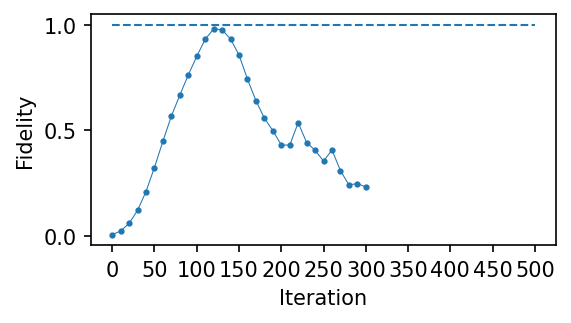

In [116]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Iteration",fontsize=10)
plt.ylabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50],[0,50,100,150,200,250,300,350,400,450,500],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 50,linewidth=1.0,linestyle="--")

plt.show()